In [1]:
import pandas as pd
import numpy as np

data_df = pd.read_csv('../imputing/imputed_mutation_matrix.csv')
data_df = data_df.drop(columns=['Unnamed: 0'])
data_df

,ABL1,ABRAXAS1,ACVR1,AGO2,AKT1,AKT2,AKT3,ALB,ALK,ALOX12B,...,WWTR1,XIAP,XPO1,XRCC2,YAP1,YES1,ZFHX3,ZNRF3,ZRSR2,MSI
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
16906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CancerTransformer(nn.Module):
    def __init__(self, num_genes=data_df.shape[1], embed_dim=128, num_heads=8, ff_dim=256, num_layers=3, dropout=0.1):
        super(CancerTransformer, self).__init__()

        # Embedding layer for binary mutation (0,1) → Continuous space
        self.embedding = nn.Linear(num_genes, embed_dim)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification head
        self.fc = nn.Sequential(
            nn.Linear(embed_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1),
            nn.Sigmoid()  # For binary classification
        )

    def forward(self, x):
        x = self.embedding(x)  # Map binary input to embedding space
        x = x.unsqueeze(1)  # Add sequence dimension for Transformer (N, Seq, D)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Pooling
        x = self.fc(x)  # Classification
        return x
    
# load the model
model = CancerTransformer()
model.load_state_dict(torch.load('../models/cancer_transformer_model.pth'))

/home/lyce/miniconda3/envs/dlg/lib/python3.11/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_23862/2561968547.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_global

<All keys matched successfully>

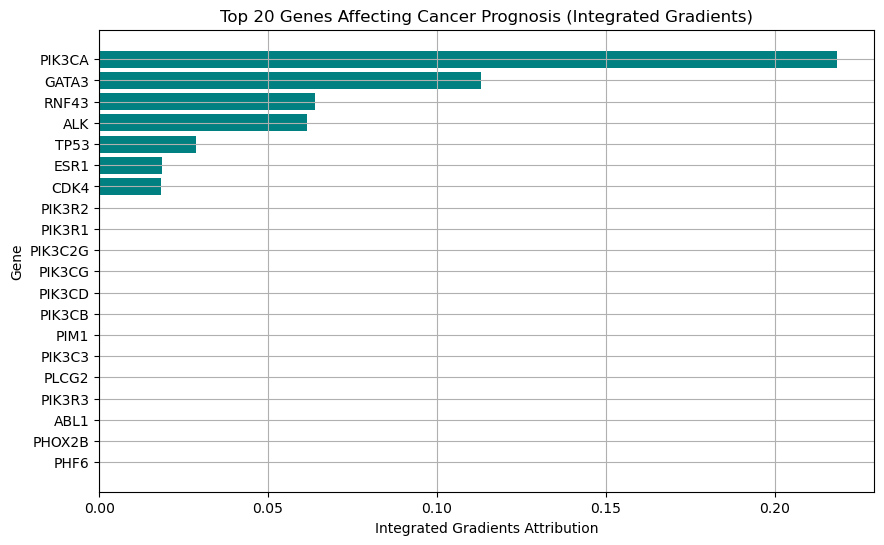

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from captum.attr import IntegratedGradients

# Ensure model is in evaluation mode
model.eval()

# Define Integrated Gradients method
ig = IntegratedGradients(model)

# Select a sample input from test set
sample_input = torch.tensor(data_df.iloc[0].values, dtype=torch.float32).unsqueeze(0)  # Shape (1, num_genes)
sample_input.requires_grad = True  # Enable gradients for IG

# Compute Integrated Gradients
attributions, _ = ig.attribute(sample_input, target=0, return_convergence_delta=True)
attributions = attributions.squeeze(0).detach().cpu().numpy()

# Get absolute feature importance
gene_importance = np.abs(attributions)

# # Get gene names
gene_names = data_df.columns.tolist()  # Assuming genes are column names

# Sort genes by importance
sorted_indices = np.argsort(-gene_importance)  # Descending order
top_genes = [gene_names[i] for i in sorted_indices[:20]]  # Top 20 important genes
top_importance = gene_importance[sorted_indices[:20]]

# Plot Feature Importances
plt.figure(figsize=(10, 6))
plt.barh(top_genes[::-1], top_importance[::-1], color='teal')  # Reverse for better visualization
plt.xlabel("Integrated Gradients Attribution")
plt.ylabel("Gene")
plt.title("Top 20 Genes Affecting Cancer Prognosis (Integrated Gradients)")
plt.grid()
plt.show()

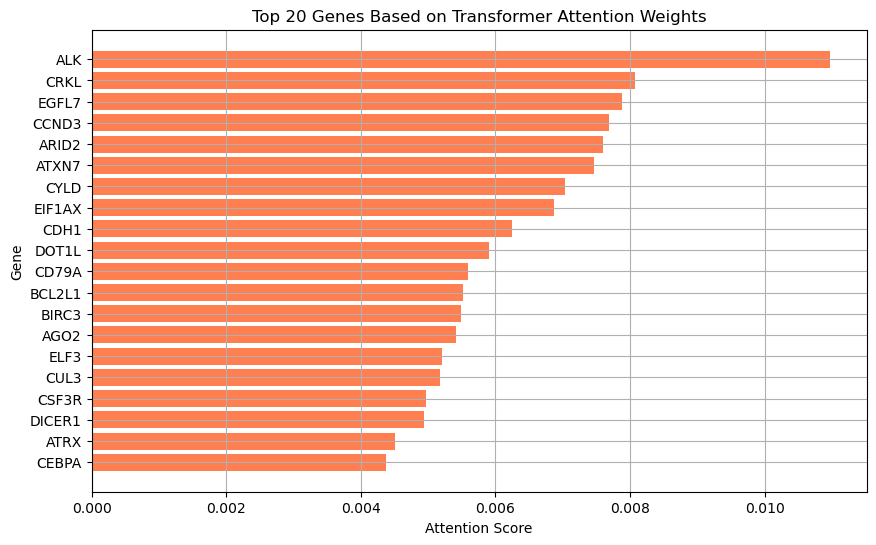

In [9]:
# Extract attention weights from the first Transformer Encoder layer
for name, param in model.named_parameters():
    if "self_attn" in name and "weight" in name:
        attention_weights = param.detach().cpu().numpy()
        break  # Get first attention layer

# Summarize attention weights across all heads
mean_attention = np.mean(attention_weights, axis=0)

# Sort genes based on attention weights
sorted_attention_indices = np.argsort(-mean_attention)[:20]  # Top 20 genes
top_attention_genes = [gene_names[i] for i in sorted_attention_indices]
top_attention_scores = mean_attention[sorted_attention_indices]

# Plot Attention Weights
plt.figure(figsize=(10, 6))
plt.barh(top_attention_genes[::-1], top_attention_scores[::-1], color='coral')
plt.xlabel("Attention Score")
plt.ylabel("Gene")
plt.title("Top 20 Genes Based on Transformer Attention Weights")
plt.grid()
plt.show()
